Importing gempy



In [1]:
# Aux imports
import gempy as gp
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import gstools as gs
import pyvista as pv
import pyvistaqt as pvqt
import PVGeo
import glob
import random
from tqdm import tqdm
from numpy import cross, eye, dot
from scipy.linalg import expm, norm
from sklearn import preprocessing
from pyvista import set_plot_theme
np.random.seed(1515)
pd.set_option('precision', 2)
%matplotlib inline
set_plot_theme('document')

No module named 'osgeo'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\pasha\python\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


We import a model from an existing folder, representing a subduction
zone with onlap relationships. The theano function is automatically
recombined to allow changes.




In [2]:
#define resolution and mesh size
reso=[80, 80, 80]
mesh_size = reso[0]*reso[1]*reso[2]
extent=[0, 1150, 0, 600, -1210, 0]
print(' mesh size: ' + str(mesh_size))

 mesh size: 512000


In [3]:
geo_data = gp.create_data('foresets', extent=[0, 1150, 0, 600, -1210, 0], resolution=reso,
                          path_o="2_orientation_data_all.csv",
                          path_i="1_point_data_all.csv")

gp.map_stack_to_surfaces(geo_data, {"Default series": ('topo'),
                                    "Strat_Series1": ('tuff'),
                                    "Strat_Series2": ('lstlens'),
                                    "Strat_Series3": ('biomicritedolomite','alkalibasalt','trachyandestictuff'),                                   
                                    "Basement": ('basement')})

Active grids: ['regular']


,surface,series,order_surfaces,color,id
0,topo,Default series,1,#015482,1
1,tuff,Strat_Series1,1,#9f0052,2
2,lstlens,Strat_Series2,1,#ffbe00,3
3,biomicritedolomite,Strat_Series3,1,#728f02,4
4,alkalibasalt,Strat_Series3,2,#443988,5
5,trachyandestictuff,Strat_Series3,3,#ff3f20,6
6,basement,Basement,1,#5DA629,7


In [4]:
geo_data.get_data()

X    Y        Z    smooth             surface   G_x  \
surface_points 0      13.00    0   -25.00  2.00e-06                topo   NaN   
               1     107.00    0  -123.00  2.00e-06                topo   NaN   
               2     201.00    0  -209.00  2.00e-06                topo   NaN   
               3     269.00    0  -297.00  2.00e-06                topo   NaN   
               4     351.00    0  -322.00  2.00e-06                topo   NaN   
...                     ...  ...      ...       ...                 ...   ...   
orientations   184   966.78  500  -880.59  1.00e-02  trachyandestictuff  0.17   
               185  1015.51  500  -934.99  1.00e-02  trachyandestictuff  0.50   
               186  1054.49  500  -970.26  1.00e-02  trachyandestictuff  0.50   
               187  1094.45  500 -1000.48  1.00e-02  trachyandestictuff  0.50   
               188  1123.69  500 -1019.63  1.00e-02  trachyandestictuff  0.50   

                         G_y   G_z  
surface_points 0         NaN   NaN  
               1         NaN   NaN  
               2         NaN   NaN  
               3         NaN   NaN  
               4         NaN   NaN  
...                      ...   ...  
orientations   184  1.00e-12  0.98  
               185  1.00e-12  0.87  
               186  1.00e-12  0.87  
               187  1.00e-12  0.87  
               188  1.00e-12  0.87  

[405 rows x 8 columns]

In [5]:
geo_data.series.df['BottomRelation'][3]='Onlap'
geo_data.series

,order_series,BottomRelation,isActive,isFault,isFinite
Default series,1,Erosion,True,False,False
Strat_Series1,2,Erosion,True,False,False
Strat_Series2,3,Erosion,True,False,False
Strat_Series3,4,Onlap,True,False,False
Basement,5,Erosion,False,False,False


C:\Users\pasha\python\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


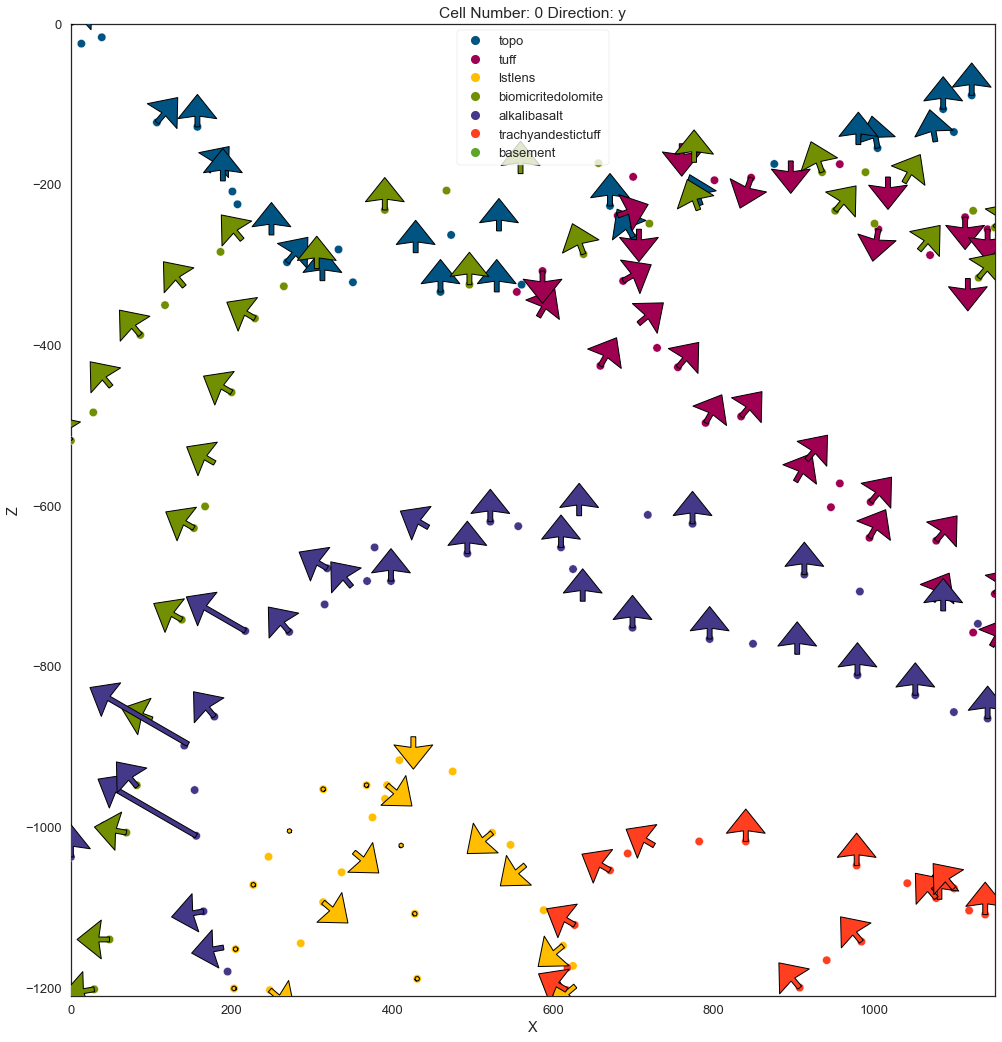

In [6]:
#for resolution of 40x40x40 : Isa - cell number=0; Hilton - cell number 35.5.

gp.plot_2d(geo_data, cell_number=0, figsize=(15,15))

In [7]:
#set topography surface for good visualization
geo_data.set_topography(source='random', fd=1.5, d_z=np.array([-50, 0]), resolution=np.array([400, 400]))

#geo_data.set_topography(source='random', fd=1.5, d_z=np.array([100, 0]), resolution=np.array([400, 400]))
#geo_model._grid.topography.save('test_topo')
#geo_model.set_topography(source='saved', filepath='test_topo.npy')

Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[    7.1875    ,     3.75      , -1202.4375    ],
       [    7.1875    ,     3.75      , -1187.3125    ],
       [    7.1875    ,     3.75      , -1172.1875    ],
       ...,
       [ 1150.        ,   596.9924812 ,   -43.16530907],
       [ 1150.        ,   598.4962406 ,   -43.15289141],
       [ 1150.        ,   600.        ,   -43.09048536]])

In [8]:
interp_data = gp.set_interpolator(geo_data, compile_theano=True,theano_optimizer='fast_compile')

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                           values
range                    1773.87
$C_o$                   74919.05
drift equations  [3, 3, 3, 3, 3]


In [9]:
%%time
sol = gp.compute_model(geo_data, compute_mesh=True, debug=False)

Wall time: 2min 42s


C:\Users\pasha\python\lib\site-packages\gempy\core\solution.py:174: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.geological_map = np.array(


C:\Users\pasha\python\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


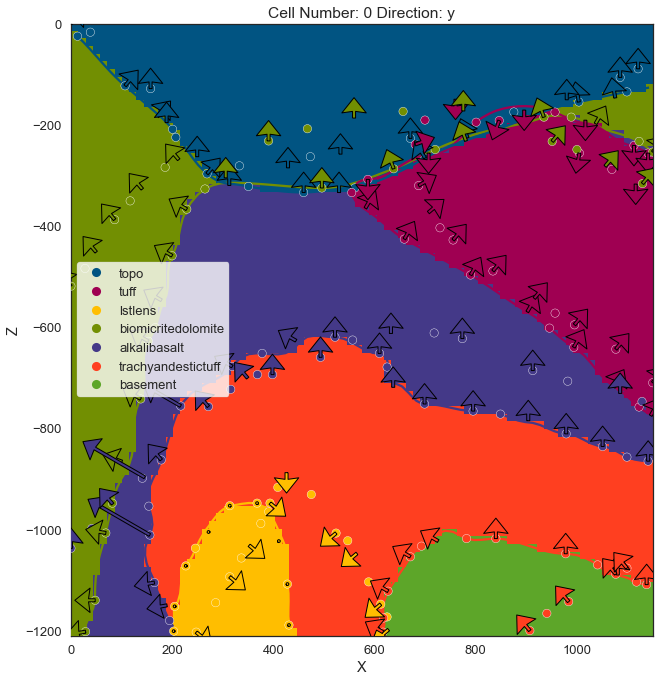

In [10]:
gp.plot_2d(geo_data, direction='y', cell_number=0, show_data=True,  figsize=(10,10))

In [33]:
p3d = gp.plot_3d(geo_data, plotter_type='background', show_lith=True, show_surfaces=True,  show_data=False, image=False,
                 show_topography=True,
                 kwargs_plot_structured_grid={'opacity': .6})

gp.save_model(geo_data)

C:\Users\pasha\python\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


True

In [11]:
### User-defined functions
def extract_domain(sol, unit):
    '''
    Extract domain coordinates from gempy model by unit name
    arguments:
        sol: Gempy solution object.
        unit: gempy unit by index
    returns:
        dom_x, dom_y, dom_z: coordinates of domain
    '''

    # new version with rounding, definitely necessary
    rounded_lithblock = sol.lith_block.round(0)
    rounded_lithblock = rounded_lithblock.astype(int)

    # mask by array of input surfaces (by id, can be from different series)
    mask = np.isin(rounded_lithblock, unit)

    # get coordinates by mask, mesh_size is defined on in[55]
    #krig_lith = sol.lith_block[mask]
    dom_grid = sol.grid.values[:mesh_size][mask]

    dom_x = dom_grid[:,0]
    dom_y = dom_grid[:,1]
    dom_z = dom_grid[:,2]

    return dom_x, dom_y, dom_z,

In [12]:
unit_count=int(np.max(sol.lith_block.round(0)))
series_count=len(sol.scalar_field_matrix)
unit_count, series_count

(7, 4)

### Geostatistics and Kriging
the script below is designed to use two different mineral grading parameters and eventually visualize both in the same grid of the model

In [13]:
#load csv file and introduce it to pandas dataframe
df=pd.read_csv('3_kriging_data_joined.csv')
df

,X,Y,Z,grade_value,grade,section
0,214.00,0,-1074.00,195.22,clusterI,9
1,229.00,0,-1051.00,195.74,clusterI,9
2,233.00,0,-1039.00,195.09,clusterI,9
3,231.00,0,-1034.00,195.44,clusterI,9
4,260.00,0,-999.00,195.36,clusterI,9
...,...,...,...,...,...,...
165,380.13,250,-541.25,250.71,clusterII,10
166,317.74,250,-571.37,250.58,clusterII,10
167,341.74,250,-569.37,250.94,clusterII,10
168,387.81,250,-543.26,250.49,clusterII,10


In [49]:
# This is to extract smaller domains from gempy by 

# 3 - lstlens, 4 - biomicrite dolomite, 5 - alkalibasalt, 6 - trachyandestictuff,

domain_x, domain_y, domain_z = extract_domain(sol, (5)) #3,6

# grid coordinate preparation
coordinates = np.array([domain_x, domain_y, domain_z])
coordinates = coordinates.swapaxes(0,1)


In [50]:
# define kriging points coordinates and grade values (Cu)
n=len(df.iloc[:,2])
x = df.iloc[:n,0]
y = df.iloc[:n,1]
z = df.iloc[:n,2]
cond_pos = np.array([x,y,z])
cond_val = df.iloc[:n,3]

# define kriging points coordinates and grade values(Lenses)

In [51]:
# grid coordinate preparation
coordinates = np.array([domain_x, domain_y, domain_z])
coordinates = coordinates.swapaxes(0,1)
    
# This is where the magic happens - GStools offers a lot of options, here a simple version with isotropic range
model = gs.Exponential(dim=3, var=np.var(cond_val), len_scale=200)
krige = gs.krige.Ordinary(model, cond_pos, cond_val)
#cond_srf = gs.CondSRF(krige)

# perform kriging
krige((coordinates[:,0],coordinates[:,1], coordinates[:,2]), mesh_type='unstructured')
# alternatively fior SGS
#cond_srf((coordinates[:,0],coordinates[:,1], coordinates[:,2]), mesh_type='unstructured')

# just convenience rename
field = krige
# alternatively for SGS
# field = cond_srf

In [52]:
# convert to pyvista mesh
pc = field.to_pyvista()

In [53]:
# 3D plotting example of Cu krige
spacing = lambda arr: np.unique(np.diff(np.unique(arr)))
voxelsize = spacing(pc.points[:,0]), spacing(pc.points[:,1]), spacing(pc.points[:,2])

pc = pc.cast_to_unstructured_grid()

grade = PVGeo.filters.VoxelizePoints(dx=voxelsize[0][0], dy=voxelsize[1][0], dz=voxelsize[2][0], 
                                        estimate=False).apply(pc)


#a = pc_Cu.plot('3d_field')
#p = pvqt.BackgroundPlotter(pc)


gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False, show_lith=True, show_surfaces=False,
                kwargs_plot_structured_grid={'opacity': .6})

gpv.p.add_mesh(grade, opacity=1, show_edges=False, lighting=False, cmap="terrain")

(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)0000028927184160

In [19]:
#density of Au ore is  19.3/cm3
#define grade intervals and check the count of voxels corresponding to the same interval
ore_interval1=[]
ore_interval2=[]
ore_dict={}
for index in tqdm(range(0, len(grade.active_scalars))):
    #for Horizon I:
    if 200>grade.active_scalars[index]>195:
        ore_interval1.append(grade.active_scalars[index])
        ore_dict.update({1: ore_interval1})
    #for Horizon II:
    elif 251>grade.active_scalars[index]>235:        
        ore_interval2.append(grade.active_scalars[index])
        ore_dict.update({2: ore_interval2})
        
#calculate volume of total voxels corresponding to a certain ore grade interval
voxel_volume=((extent[1]-extent[0])/reso[0])*((extent[3]-extent[2])/reso[1])*((extent[5]-extent[4])/reso[2])

for i in range(1,3):
    ore_avrg_grade=np.mean(ore_dict[i])
    volume=len(ore_dict[i])*(voxel_volume)
    print("Horizon{} = ".format(i),volume)
    print("Average ore grade=", ore_avrg_grade)

100%|████████████████████████████████| 328485/328485 [03:01<00:00, 1814.37it/s]

Horizon1 =  330700302.5390625
Average ore grade= 197.34561017253375
Horizon2 =  6064439.6484375
Average ore grade= 240.64447970347868


### Extract kriged data

In [48]:
%%time
main_array=pc.points.tolist()
added_array=grade.active_scalars.tolist()
n=len(main_array)

for index in range(0,n,1):
    main_array[index].append(added_array[index])
grade=pd.DataFrame(main_array, columns=['X','Y','Z','grade'])
grade

Wall time: 836 ms


,X,Y,Z,grade
0,11.5,66.0,-1197.9,198.77
1,11.5,66.0,-1173.7,198.68
2,11.5,66.0,-1149.5,198.62
3,11.5,66.0,-1125.3,198.59
4,11.5,66.0,-1101.1,198.59
...,...,...,...,...
80210,1138.5,594.0,-471.9,199.48
80211,1138.5,594.0,-447.7,199.55
80212,1138.5,594.0,-423.5,199.63
80213,1138.5,594.0,-399.3,199.72


In [49]:
#drill boreholess!!
def krige_boreholes(b_count):
    borehole_count=range(0,b_count,1)
    rand_ind=random.sample(range(0,len(grade)),b_count)
    dict_all={}
    boreholes_dict={}

    for index in tqdm(borehole_count):
        list_temp=[]
        for row in grade.itertuples():
            if (grade.iloc[rand_ind[index]].X==row.X and grade.iloc[rand_ind[index]].Y==row.Y):
                list_temp.append([row.X,row.Y,row.Z,row.grade])
                
        dict_all.update({index+1:list_temp})

    for index in range(0,b_count,1): 
        data_temp = pd.DataFrame(dict_all[index+1])
        data_temp.columns=['X','Y','Z','grade']
        data_temp.loc[:, 'borehole']=index+1
        boreholes_dict.update({index+1:data_temp})
    return boreholes_dict
        
boreholes=krige_boreholes(100)

100%|████████████████████████████████████████| 100/100 [11:13<00:00,  6.74s/it]


In [50]:
drill_all = pd.concat(boreholes.values(), ignore_index=True)
drill_all

,X,Y,Z,grade,borehole
0,816.5,414.0,-1197.9,198.68,1
1,816.5,414.0,-1173.7,198.50,1
2,816.5,414.0,-1149.5,198.32,1
3,816.5,414.0,-1125.3,198.13,1
4,816.5,414.0,-1101.1,197.94,1
...,...,...,...,...,...
3692,356.5,450.0,-254.1,209.01,100
3693,356.5,450.0,-229.9,208.22,100
3694,356.5,450.0,-205.7,207.49,100
3695,356.5,450.0,-181.5,206.84,100


In [51]:
list_tempo=[]
for index in range(0,len(drill_all),15):
    list_tempo.append(drill_all.iloc[index])
br=pd.DataFrame(list_tempo)

br.to_csv('3_kriging_100.csv')
br

,X,Y,Z,grade,borehole
0,816.5,414.0,-1197.9,198.68,1.0
15,816.5,414.0,-834.9,195.92,1.0
30,816.5,414.0,-471.9,196.99,1.0
45,195.5,522.0,-1197.9,199.58,2.0
60,195.5,522.0,-399.3,211.51,2.0
...,...,...,...,...,...
3630,701.5,522.0,-133.1,201.16,98.0
3645,1046.5,282.0,-810.7,198.21,99.0
3660,356.5,450.0,-1028.5,198.36,100.0
3675,356.5,450.0,-665.5,213.73,100.0


In [52]:
vertices = drill_all[['X','Y','Z']].values
kriged=pv.PolyData(vertices)
kriged['grade'] = drill_all['grade'].values
kriged

PolyData (0x16a5e0bbca0)
  N Cells:	3697
  N Points:	3697
  X Bounds:	8.050e+01, 1.138e+03
  Y Bounds:	6.000e+00, 5.940e+02
  Z Bounds:	-1.198e+03, -8.470e+01
  N Arrays:	1

In [53]:
p = pvqt.BackgroundPlotter()
gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False, show_lith=True, show_surfaces=True,
                kwargs_plot_structured_grid={'opacity': .3})

#creating the grade mesh calculated with kriging (colormap) 
gpv.p.add_mesh(kriged, scalars='grade', opacity=1, cmap='viridis', point_size=5)

C:\Users\pasha\python\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)00000169F2755BE0

### Extract orientation data from the solution

In [13]:
#define the function to calculate gradient (dict_spec)

def get_gradient(sol, res, dim):
    '''
    Calculate gradient from model solution
    '''
    # scalar field as meshgrid
    dict_all={}
    dict_spec={}
    for index in range(0,series_count,1):
        scalar_mgrid = sol.scalar_field_matrix[index].reshape(res)

        # calculate gradient
        gx, gy, gz = np.gradient(scalar_mgrid)

       
        vectors = np.array([gx.reshape(int(res[0] ** dim)), gy.reshape(int(res[0] ** dim)), gz.reshape(int(res[0] ** dim))])
        vectors = np.swapaxes(vectors, 0, 1)
        vectors = preprocessing.normalize(vectors, norm='l2')
        dict_all.update({index:vectors})
         
    
    for index in range(0,series_count,1):
            data_temp = pd.DataFrame(dict_all[index])
            dict_spec.update({'series_{}'.format(index):data_temp})
    return dict_spec

dict_spec=get_gradient(sol, res=[50,50,50], dim=3)

#define cell locations and correspoding domain name
x=sol.grid.regular_grid.values[:, 0]
y=sol.grid.regular_grid.values[:, 1]
z=sol.grid.regular_grid.values[:, 2]
formation=sol.lith_block

#add cell locations and domain names to the gradient dataframe
for key,value in dict_spec.items():
    #load coordinate and formation array to the whole series dataframes
    value["X"]=x
    value['Y']=y
    value['Z']=z
    value['formation']=formation
    #value = value.reset_index()
    #define column names
    value.columns=['G_x','G_y','G_z','X','Y','Z','formation'] 

In [16]:
dict_spec['series_0']=dict_spec['series_0'][dict_spec['series_0'].formation==1]
dict_spec['series_1']=dict_spec['series_1'][dict_spec['series_1'].formation==2]
dict_spec['series_2']=dict_spec['series_2'][dict_spec['series_2'].formation==3]
dict_spec['series_3']=dict_spec['series_3'].drop(dict_spec['series_3'][(dict_spec['series_3'].formation<=3)].index)

orientations = pd.concat([dict_spec['series_0'],dict_spec['series_1'],dict_spec['series_2'],dict_spec['series_3']], ignore_index=True)
orientations

,G_x,G_y,G_z,X,Y,Z,formation
0,0.67,-5.31e-03,0.74,11.5,6.0,-12.1,1.0
1,0.66,-5.39e-03,0.75,11.5,18.0,-12.1,1.0
2,0.66,-5.79e-03,0.75,11.5,30.0,-12.1,1.0
3,0.65,-6.90e-03,0.76,11.5,42.0,-12.1,1.0
4,0.63,-8.81e-03,0.77,11.5,54.0,-12.1,1.0
...,...,...,...,...,...,...,...
124789,0.48,5.40e-02,0.87,1138.5,594.0,-447.7,5.0
124790,0.53,2.97e-02,0.85,1138.5,594.0,-423.5,5.0
124791,0.59,1.50e-02,0.80,1138.5,594.0,-399.3,5.0
124792,0.66,1.43e-02,0.75,1138.5,594.0,-375.1,5.0


### Domain extraction, beginning of reverse modelling with extraction of wells

In [18]:
unit=range(0,unit_count+1)
for index in unit:
    domain_x, domain_y, domain_z = extract_domain(sol, (unit[index+1]))
    coordinates = np.array([domain_x, domain_y, domain_z])
    coordinates = coordinates.swapaxes(0,1)
    data=pd.DataFrame(coordinates, columns=['X', 'Y','Z'])
    data.loc[:, 'formation'] =unit[index+1]
    data.to_csv(r'data_extracted/ideal/unit_{}.csv'.format(unit[index+1]), mode="w", index=False)

IndexError: range object index out of range

In [19]:
# if you want to join all files in the same folder
path =r'data_extracted/ideal'

filenames = glob.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame
ideal = pd.concat(dfs, ignore_index=True)
ideal

,X,Y,Z,formation
0,11.5,6.0,-12.1,1
1,11.5,18.0,-12.1,1
2,11.5,30.0,-12.1,1
3,11.5,42.0,-12.1,1
4,11.5,54.0,-12.1,1
...,...,...,...,...
124995,1138.5,594.0,-1149.5,7
124996,1138.5,594.0,-1125.3,7
124997,1138.5,594.0,-1101.1,7
124998,1138.5,594.0,-1076.9,7


In [20]:
df_same = orientations.merge(ideal, left_on=('X','Y','Z','formation'), right_on=('X','Y','Z','formation'), how='inner')
df_same = df_same[df_same.formation != unit_count]
df_same

C:\Users\pasha\python\lib\site-packages\pandas\core\reshape\merge.py:1141: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


,G_x,G_y,G_z,X,Y,Z,formation
0,0.67,-5.31e-03,0.74,11.5,6.0,-12.1,1.0
1,0.66,-5.39e-03,0.75,11.5,18.0,-12.1,1.0
2,0.66,-5.79e-03,0.75,11.5,30.0,-12.1,1.0
3,0.65,-6.90e-03,0.76,11.5,42.0,-12.1,1.0
4,0.63,-8.81e-03,0.77,11.5,54.0,-12.1,1.0
...,...,...,...,...,...,...,...
99219,0.47,1.08e-01,0.88,1138.5,594.0,-496.1,5.0
99220,0.46,8.21e-02,0.88,1138.5,594.0,-471.9,5.0
99221,0.53,2.97e-02,0.85,1138.5,594.0,-423.5,5.0
99222,0.66,1.43e-02,0.75,1138.5,594.0,-375.1,5.0


In [78]:
#drill boreholess!!
def d_boreholes(b_count):
    borehole_count=range(0,b_count,1)
    rand_ind=random.sample(range(0,len(df_same)),b_count)
    dict_all={}
    boreholes_dict={}

    for index in tqdm(borehole_count):
        list_temp=[]
        for row in df_same.itertuples():
            if (df_same.iloc[rand_ind[index]].X==row.X and df_same.iloc[rand_ind[index]].Y==row.Y):
                list_temp.append([row.X,row.Y,row.Z,row.G_x, row.G_y, row.G_z, row.formation])
                
        dict_all.update({index+1:list_temp})

    for index in range(0,b_count,1): 
        data_temp = pd.DataFrame(dict_all[index+1])
        data_temp.columns=['X','Y','Z','G_x','G_y','G_z','formation']
        data_temp.loc[:, 'borehole']=index+1
        boreholes_dict.update({index+1:data_temp})
    return boreholes_dict

#define desired number of boreholes
boreholes_dict=d_boreholes(100)

#join all borehole data into one dataframe
df = pd.concat(boreholes_dict.values(), ignore_index=True)
# boreholes_dict.to_csv('test100')

#load joined csv dataset
bore_count = df['borehole'].nunique()

#create mesh grid and define vertices, convert it to a pyvista poly data
vertices = df[['X', 'Y', 'Z']].values
grid=pv.PolyData(vertices)
grid['formation'] = df['formation'].values

In [84]:
unit=('topo','tuff', 'lstlens','biomicritedolomite','alkalibasalt','trachyandestictuff')
for index in range(1,unit_count):
    df['formation'] = df.loc[:,'formation'].replace(index,unit[index-1])
# boreholes[boreholes['formation']=='quartzite2'] - just for checking the dataset
df

,X,Y,Z,G_x,G_y,G_z,formation,borehole
0,678.5,570.0,-84.7,-0.23,0.15,0.96,topo,1
1,678.5,570.0,-60.5,-0.20,0.15,0.97,topo,1
2,678.5,570.0,-12.1,-0.15,0.13,0.98,topo,1
3,678.5,570.0,-1197.9,-0.95,-0.06,0.32,trachyandestictuff,1
4,678.5,570.0,-1173.7,-0.96,-0.06,0.28,trachyandestictuff,1
...,...,...,...,...,...,...,...,...
772,770.5,474.0,-278.3,0.09,-0.03,1.00,alkalibasalt,9
773,770.5,474.0,-181.5,0.40,-0.26,0.88,alkalibasalt,9
774,770.5,474.0,-157.3,0.47,-0.28,0.84,alkalibasalt,9
775,770.5,474.0,-133.1,0.46,-0.27,0.84,alkalibasalt,9


In [52]:
p = pvqt.BackgroundPlotter()
gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False, show_lith=True, show_surfaces=True,
                kwargs_plot_structured_grid={'opacity': .3})

#creating the grade mesh calculated with kriging (colormap) 
gpv.p.add_mesh(grid, scalars='formation', opacity=1, cmap='viridis', point_size=15)

C:\Users\pasha\python\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)0000020788733040

### Extract data from boreholes to generate point data for the regenerated model

In [85]:
#picking lowermost boundary for each formation through the borehole data 

dict_all=[]
list_temp=[]

for br in range(1,bore_count+1,1):
    for fr in range(1,form_count+1,1):
          list_temp.append(df[(df['borehole']==br) & (df['formation']==unit[fr-2])])
list_temp2=[]
for i in list_temp:
    if(not i.empty):
        list_temp2.append(i.iloc[0])
df_b=pd.DataFrame(list_temp2, index=range(0,len(list_temp2),1))
del df_b['borehole']
#df_b[df_b['formation']=='quartzite2']
df_b1 = df_b[df_b.formation != 'lstlens']
df_b1

,X,Y,Z,G_x,G_y,G_z,formation
0,678.5,570.0,-1197.9,-0.95,-0.06,0.32,trachyandestictuff
1,678.5,570.0,-84.7,-0.23,0.15,0.96,topo
2,678.5,570.0,-375.1,0.02,-0.02,1.00,alkalibasalt
3,655.5,270.0,-1197.9,-0.82,0.45,0.36,trachyandestictuff
4,655.5,270.0,-181.5,-0.10,-0.14,0.99,topo
...,...,...,...,...,...,...,...
64,333.5,546.0,-1197.9,-0.73,-0.20,0.65,alkalibasalt
65,701.5,114.0,-1076.9,-0.59,0.53,0.61,trachyandestictuff
66,701.5,114.0,-181.5,-0.22,-0.09,0.97,topo
67,701.5,114.0,-375.1,0.79,-0.28,0.55,tuff


In [86]:
#picking lowermost boundary for each formation through the borehole data 

dict_all1=[]
list_temp1=[]

for br in range(1,bore_count+1,1):
    for fr in range(1,form_count+1,1):
          list_temp1.append(df[(df['borehole']==br) & (df['formation']==unit[fr-2])])
list_temp2=[]
for df in list_temp1:
    if(not df.empty):
        list_temp2.append(df.iloc[-1])
df_f=pd.DataFrame(list_temp2, index=range(0,len(list_temp2),1))
del df_f['borehole']
df_f=df_f[df_f['formation']=='lstlens']
df_f

,X,Y,Z,G_x,G_y,G_z,formation
19,333.5,30.0,-1028.5,0.52,-0.36,-0.77,lstlens
37,356.5,342.0,-1125.3,0.69,-0.39,-0.61,lstlens
43,333.5,438.0,-1197.9,0.17,-0.20,-0.97,lstlens
49,540.5,210.0,-1028.5,-0.67,0.10,-0.74,lstlens
57,333.5,414.0,-1197.9,0.26,-0.24,-0.94,lstlens


In [87]:
joined=pd.concat([df_b1,df_f])
#joined[joined['formation']=='pipe']

t = pd.CategoricalDtype(categories=['topo','tuff', 'lstlens','biomicritedolomite','alkalibasalt','trachyandestictuff'], ordered=True)
joined['formation']=pd.Series(joined.formation, dtype=t)
joined.sort_values(by=['formation'],inplace=True)
joined

,X,Y,Z,G_x,G_y,G_z,formation
18,333.5,30.0,-302.5,0.16,-5.36e-02,0.98,topo
36,356.5,342.0,-181.5,0.21,-5.04e-01,0.84,topo
42,333.5,438.0,-133.1,0.23,-2.16e-01,0.95,topo
32,149.5,222.0,-108.9,0.38,3.49e-03,0.93,topo
63,333.5,546.0,-108.9,0.23,1.38e-02,0.97,topo
...,...,...,...,...,...,...,...
10,540.5,486.0,-1197.9,-0.98,6.97e-02,0.16,trachyandestictuff
6,218.5,126.0,-1197.9,-0.67,-1.03e-02,-0.74,trachyandestictuff
3,655.5,270.0,-1197.9,-0.82,4.51e-01,0.36,trachyandestictuff
59,885.5,18.0,-931.7,0.23,-1.21e-02,0.97,trachyandestictuff


In [88]:
joined.to_csv(r'data_all_test20.csv', index = False)